In [81]:
!rm -rf mask_old/

In [24]:
png_lst = glob("drr/*png")
mask_lst = glob("mask/*png")

In [26]:
for png in png_lst:
    img = np.array(Image.open(png))[-512:]
    Image.fromarray(img).save(f"drr_512/{png.split('/')[-1]}")
    
for msk in mask_lst:
    img = np.array(Image.open(msk))[-512:]
    Image.fromarray(img).save(f"mask_512/{msk.split('/')[-1]}")

In [28]:
png_lst = glob("drr_512/*png")
for png in png_lst:
    sz = Image.open(png).size
    if sz[1] != 512:
        Image.fromarray(np.array(Image.open(png))[-sz[1]:]).resize((512, 512)).save(png)
        print(png)

drr_512/800ACF15C5100518_drr.png
drr_512/A09CBBD45477851D_drr.png


In [29]:
msk_lst = glob("mask_512/*png")
for msk in msk_lst:
    sz = Image.open(msk).size
    if sz[1] != 512:
        Image.fromarray(np.array(Image.open(msk))[-sz[1]:]).resize((512, 512)).save(msk)
        print(msk)

mask_512/800ACF15C5100518_1.png
mask_512/800ACF15C5100518_2.png
mask_512/800ACF15C5100518_3.png
mask_512/800ACF15C5100518_4.png
mask_512/800ACF15C5100518_5.png
mask_512/A09CBBD45477851D_1.png
mask_512/A09CBBD45477851D_2.png
mask_512/A09CBBD45477851D_3.png
mask_512/A09CBBD45477851D_4.png
mask_512/A09CBBD45477851D_5.png


AttributeError: 'AxesImage' object has no attribute 'shape'

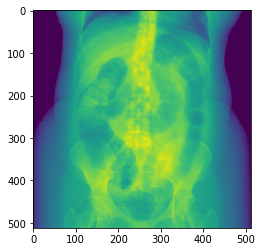

In [13]:
plt.imshow(img)

# Import

In [3]:
import os
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import pydicom
from PIL import Image
import cv2

from glob import glob
from tqdm import tqdm

from matplotlib import pyplot as plt


IMG_EXTENSION = ['.dcm', '.DCM']


def check_extension(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSION)


def load_scans_path(folder_path):
    """
    find 'IMG_EXTENSION' file paths in folder.
    return list
    
    """
    
    img_paths = []
    assert os.path.isdir(folder_path), '%s is not a valid directory'

    for root, _, fnames in sorted(os.walk(folder_path)):
        for fname in fnames:
            if check_extension(fname):
                path = os.path.join(root, fname)
                img_paths.append(path)
    return img_paths[:]


def load_ct_scans(patient_folder_path):
    """
    Function of Loading CT-scans "per patient"
    patient path to CT slices(HU)
    input: patient folder path -> list or tuple
    output: File Meta Information, CT sclices -> tuple
    """
    # call all image paths in directory
    dcm_paths = load_scans_path(patient_folder_path)
    
    slices = [pydicom.read_file(dcm_path, force=True) for dcm_path in dcm_paths]
    
    # **Sort the slices in ascending order
    
    for idx, sl in enumerate(slices):
        try:
            _ = sl.ImagePositionPatient[2]
        except AttributeError:
            slices.pop(idx)
            print(idx)
        
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        
    # stack slices
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)
    
    # convert to HU
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    hu_images = images.astype(np.float64) * slope + intercept
    hu_images = set_outside_scanner_to_air(hu_images.astype(np.int16))
    
    # return header of first dicom and stacked CT slices
    return slices[0], hu_images


def set_outside_scanner_to_air(hu_pixelarrays):
    """
    Pixel Padding Value Attribute(0028,0120) -> air
    """
    hu_pixelarrays[hu_pixelarrays < -1024] = -1024
    
    return hu_pixelarrays


def transform_to_hu(dicom_info, image):
    image = set_outside_scanner_to_air(image)
    
    intercept = dicom_info.RescaleIntercept
    slope = dicom_info.RescaleSlope
    hu_image = image.astype(np.float64) * slope + intercept
    hu_image = set_outside_scanner_to_air(hu_image.astype(np.int16))
    return hu_image


def windowing(img, window):
    w_level, w_width = window
    w_min = w_level - (w_width / 2)
    w_max = w_level + (w_width / 2)
    window_image = img.copy()
    window_image[window_image < w_min] = w_min
    window_image[window_image > w_max] = w_max

    return window_image
    
    
def dcms_to_imgs(dcms):
    dcms.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    images = np.stack([file.pixel_array for file in dcms])
    images = images.astype(np.int16)

    # convert to HU
    intercept = dcms[0].RescaleIntercept
    slope = dcms[0].RescaleSlope
    hu_images = images.astype(np.float64) * slope + intercept
    hu_images = set_outside_scanner_to_air(hu_images.astype(np.int16))
    return hu_images


def sample_stack(stacks, cols=10, start_with=0, show_every=1, vmin=-1000, vmax=1000):
    rows = len(stacks)//cols
    fig,ax = plt.subplots(rows+1,cols,figsize=[25,rows*3])
    for i in range(len(stacks)):
        ind = start_with + i*show_every
        ax[i//cols,i % cols].set_title(f'{stacks[ind].get("SeriesNumber")}')
        ax[i//cols,i % cols].imshow(stacks[ind].pixel_array, vmin=vmin, vmax=vmax,cmap='gray')
        ax[i//cols,i % cols].axis('off')        
    plt.show()
    
    
def imgs_stack(stacks, cols=10, start_with=0, show_every=1):
    rows = len(stacks)//cols
    fig,ax = plt.subplots(rows+1,cols,figsize=[40,rows*5])
    for i in range(len(stacks)):
        ind = start_with + i*show_every
        ax[i//cols,i % cols].imshow(stacks[ind],cmap='gray')
        ax[i//cols,i % cols].axis('off')        
    plt.show()

In [4]:
BASE_DIR = "./ctpel/*"
path = f"{glob(BASE_DIR)[0]}/im_1/*.dcm"

In [37]:
ds = pydicom.read_file("/home/ctpel/ctpel/02781BB458B7EEE0/im_6/x0000.dcm")

In [38]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 180
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced SR Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.49019841724910667216684881556691381641
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.752.24.3.3.25.7
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Enhanced SR Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.49019841724910667216684881556691381641
(0008, 0020) Study Date                          DA: '20140914'
(0008, 0021) Series Date                         DA: '20210608'
(0008, 0023) Content Date                        DA: '20210608'
(0008, 0030) Study Time                          TM:

In [31]:
ds[0x070, 0x001][0][0x070, 0x008][0][0x070, 0x006].value

'Right Greater Trochanter'

In [34]:
for d in ds[0x070, 0x001]:
    try:
        print(d[0x070, 0x008][0][0x070, 0x006].value)
    except:
        continue

Right Greater Trochanter
Left Greater Trochanter
Right Lesser Trochanter
Left Lesser Trochanter
Right Femur Head Center
Left Femur Head Center
Right Sacroiliac Joint Upper End
Left Sacroiliac Joint Upper End
Right Sacroiliac Joint Lower End
Left Sacroiliac Joint Lower End
Right Anterior Superior Iliac Spine
Left Anterior Superior Iliac Spine
Pubic Symphysis Upper End
Promontory of  sacrum
Coccyx tip


In [ ]:
(0070, 0001)  Graphic Annotation Sequence  30 item(s) ---- 
   (0008, 1140)  Referenced Image Sequence  1 item(s) ---- 
      (0008, 1150) Referenced SOP Class UID            UI: CT Image Storage
      (0008, 1155) Referenced SOP Instance UID         UI: 61.7.339696782548091506543568395297847884602
      ---------
   (0070, 0002) Graphic Layer                       CS: 'LANDMARKS'
   (0070, 0008)  Text Object Sequence  1 item(s) ---- 
      (0070, 0004) Anchor Point Annotation Units       CS: 'PIXEL'
      (0070, 0006) Unformatted Text Value              ST: 'Right Greater Trochanter'
      (0070, 0014) Anchor Point                        FL: [149.0, 303.4859924316406]
      (0070, 0015) Anchor Point Visibility             CS: 'N'
      ---------
   ---------
   (0008, 1140)  Referenced Image Sequence  1 item(s) ---- 
      (0008, 1150) Referenced SOP Class UID            UI: CT Image Storage
      (0008, 1155) Referenced SOP Instance UID         UI: 61.7.339696782548091506543568395297847884602

In [12]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 178
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Grayscale Softcopy Presentation State Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.10534075519597280400578542257685028488
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.752.24.3.3.25.7
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Grayscale Softcopy Presentation State Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.10534075519597280400578542257685028488
(0008, 0020) Study Date                          DA: '20140914'
(0008, 0021) Series Date                         DA: ''
(0008, 0030) Study Time                          TM: ''
(0008, 0031) Ser

In [ ]:
path = f"{glob(BASE_DIR)[0]}/im_1/*.dcm"

slices = []
for fname in glob(path):
    slices.append(pydicom.dcmread(fname, force=True))
slices = sorted(slices, key=lambda s: s[0x020, 0x032][-1])

ps = slices[0].PixelSpacing
ss = slices[1][0x020, 0x032][-1] - slices[0][0x020, 0x032][-1]
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

mask_path = glob(f"{glob(BASE_DIR)[i]}/im_3/*.dcm")
mask_dcm = pydicom.dcmread(mask_path[0], force=True)
masked_slices = mask_dcm[0x008, 0x1115][0][0x008, 0x114a]

uids_masked = []
for s in masked_slices:
    uids_masked.append(s[0x008, 0x1155].value)

uids_all = []
for s in slices:
    uids_all.append(s[0x008, 0x018].value)

roi = []
for j in uids_masked:
    roi.append(uids_all.index(j))

#     roi_slices = slices[min(roi):max(roi)+1]
roi_slices = slices[:]
roi_imgs = dcms_to_imgs(roi_slices)
window_roi_img = windowing(roi_imgs, [300, 1800])

img_shape = list(roi_slices[0].pixel_array.shape)
img_shape.append(len(roi_slices))
roi_img3d = np.zeros(img_shape)

for j, s in enumerate(window_roi_img):
        roi_img3d[:, :, -(j+1)] = s

segment_dict = {x: [] for x in range(1,6)}
for s in mask_dcm[0x5200, 0x9230]:
    uid = s[0x008, 0x9124][0][0x008, 0x2112][0][0x008, 0x1155].value
    segment_num = s[0x062, 0x00a][0][0x062, 0x00b].value

    segment_dict[segment_num].append(uid)

roi_dict = {x: [] for x in range(1,6)}
for seg_num in segment_dict:
    for j in segment_dict[seg_num]:
        roi_dict[seg_num].append(uids_all.index(j))

mask_arr = mask_dcm.pixel_array
segment_arr_dict = dict()
idx = 0
for seg_num in roi_dict:
    seg_img3d = np.zeros(img_shape)
    for j in roi_dict[seg_num]:
        seg_img3d[:, :, -(j+1)] = mask_arr[idx]
        idx += 1
    segment_arr_dict[seg_num] = seg_img3d

img_dict = dict()
for j in range (1,6):
    img_dict[j]=np.array(np.max(segment_arr_dict[j].T, axis=2)*255).astype(np.uint8)
    Image.fromarray(img_dict[j]).convert("L").resize((img_dict[j].shape[1], int(img_dict[j].shape[0]*cor_aspect))).save(f"mask/{glob(BASE_DIR)[i].split('/')[-1]}_{j}.png")

drr_arr = np.mean(roi_img3d.T, axis=2)
drr_arr = (drr_arr - np.min(drr_arr)) / (np.max(drr_arr) - np.min(drr_arr))
drr_arr = np.array(drr_arr*255).astype(np.uint8)
Image.fromarray(drr_arr).convert("L").resize((img_dict[j].shape[1], int(img_dict[j].shape[0]*cor_aspect))).save(f"drr/{glob(BASE_DIR)[i].split('/')[-1]}_drr.png")

In [ ]:
for i in tqdm(range(len(glob(BASE_DIR)))):
    path = f"{glob(BASE_DIR)[i]}/im_1/*.dcm"
    
    slices = []
    for fname in glob(path):
        slices.append(pydicom.dcmread(fname, force=True))
    slices = sorted(slices, key=lambda s: s[0x020, 0x032][-1])
    
    ps = slices[0].PixelSpacing
    ss = slices[1][0x020, 0x032][-1] - slices[0][0x020, 0x032][-1]
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]
    
    mask_path = glob(f"{glob(BASE_DIR)[i]}/im_3/*.dcm")
    mask_dcm = pydicom.dcmread(mask_path[0], force=True)
    masked_slices = mask_dcm[0x008, 0x1115][0][0x008, 0x114a]
    
    uids_masked = []
    for s in masked_slices:
        uids_masked.append(s[0x008, 0x1155].value)
        
    uids_all = []
    for s in slices:
        uids_all.append(s[0x008, 0x018].value)
        
    roi = []
    for j in uids_masked:
        roi.append(uids_all.index(j))
        
#     roi_slices = slices[min(roi):max(roi)+1]
    roi_slices = slices[:]
    roi_imgs = dcms_to_imgs(roi_slices)
    window_roi_img = windowing(roi_imgs, [300, 1800])
    
    img_shape = list(roi_slices[0].pixel_array.shape)
    img_shape.append(len(roi_slices))
    roi_img3d = np.zeros(img_shape)

    for j, s in enumerate(window_roi_img):
            roi_img3d[:, :, -(j+1)] = s
            
    segment_dict = {x: [] for x in range(1,6)}
    for s in mask_dcm[0x5200, 0x9230]:
        uid = s[0x008, 0x9124][0][0x008, 0x2112][0][0x008, 0x1155].value
        segment_num = s[0x062, 0x00a][0][0x062, 0x00b].value

        segment_dict[segment_num].append(uid)
        
    roi_dict = {x: [] for x in range(1,6)}
    for seg_num in segment_dict:
        for j in segment_dict[seg_num]:
            roi_dict[seg_num].append(uids_all.index(j))
            
    mask_arr = mask_dcm.pixel_array
    segment_arr_dict = dict()
    idx = 0
    for seg_num in roi_dict:
        seg_img3d = np.zeros(img_shape)
        for j in roi_dict[seg_num]:
            seg_img3d[:, :, -(j+1)] = mask_arr[idx]
            idx += 1
        segment_arr_dict[seg_num] = seg_img3d
    
    img_dict = dict()
    for j in range (1,6):
        img_dict[j]=np.array(np.max(segment_arr_dict[j].T, axis=2)*255).astype(np.uint8)
        Image.fromarray(img_dict[j]).convert("L").resize((img_dict[j].shape[1], int(img_dict[j].shape[0]*cor_aspect))).save(f"mask/{glob(BASE_DIR)[i].split('/')[-1]}_{j}.png")
                
    drr_arr = np.mean(roi_img3d.T, axis=2)
    drr_arr = (drr_arr - np.min(drr_arr)) / (np.max(drr_arr) - np.min(drr_arr))
    drr_arr = np.array(drr_arr*255).astype(np.uint8)
    Image.fromarray(drr_arr).convert("L").resize((img_dict[j].shape[1], int(img_dict[j].shape[0]*cor_aspect))).save(f"drr/{glob(BASE_DIR)[i].split('/')[-1]}_drr.png")

 24%|██▍       | 22/90 [26:20<1:23:44, 73.89s/it]

In [72]:
len(window_roi_img)

267

In [73]:
img_shape

[512, 512, 267]

In [75]:
len(roi_slices)

267